# Proyecto Mecánica Estadística Computacional 
# Esteban Porras Marín C26021

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Se quiere simular el modelo de lattice-gas mediante técnicas de Monte-Carlo, para esto definimos los siguientes parámetros a utilizar:

In [2]:
# Parámetros
L = 32 # Tamaño de la grilla
T = np.linspace(0.1,15.0,100) # Rango de temperaturas
epsilon = 1.0 # Energía de interacción
kb = 1.0 # Constante de boltzmann J/K
mu = 1.0 # Potencial químico

E_0 = np.random.choice([0,1], size=(L,L)) # Configuración inicial aleatoria

Para esto usamos el Hamiltoniano normalmente usado para este modelo:

$$
 H = -\epsilon \sum_{\langle i,j \rangle} n_in_j - \mu \sum_i n_i 
$$

Donde la primera sumatoria es sobre los vecinos (arriba, abajo, derecha, izquierda) y la segunda solo en la propia posición. 

Escribimos el Hamiltoniano en python de la siguiente manera:

In [3]:
def Hamiltoniano(Ei, mu, epsilon): # Cálculo del Hamiltoniano
    Lx, Ly = Ei.shape 
    H = 0.0 
    for i in range(Lx):
        for j in range(Ly):
            H += -epsilon * Ei[i,j] * Ei[(i+1) % Lx, j] # Interacción con el vecino inferior
            H += -epsilon * Ei[i,j] * Ei[i ,(j+1) % Ly] # Interacción con el vecino derecho
            # Solo calculamos con respecto a los vecinos inferior y derecho para evitar doble conteo
            H += -mu * Ei[i,j]
            # Hago % Lx debido a que quiero condiciones de frontera periódicas
    return H 

Para el algoritmo de metropolis necesitaremos un $\Delta E$, el cual no calcularemos realizando $\Delta E = H_2 - H_1$ pues por cada posición deberiamos calcular dos energías. En cambio .... llegamos a la expresión análitica que:
$$
\Delta E = \epsilon (2n_{ij} -1) \sum_{i,j} n_{vecinos} + \mu (2n_{ij} -1)
$$

donde 
$$
\sum_{i,j} n_{vecinos} = n_{i+1,j} + n_{i-1,j} + n_{i,j+1} + n_{i,j-1}
$$

In [4]:
def delta_E(Ei, i, j, epsilon, mu):
    n_ij = Ei[i, j]
    Lx, Ly = Ei.shape

    # Vecinos 
    n_up    = Ei[(i-1) % Lx, j] # vecino abajo
    n_down  = Ei[(i+1) % Lx, j] # vecino arriba
    n_left  = Ei[i, (j-1) % Ly] # vecino izquierda
    n_right = Ei[i, (j+1) % Ly] # vecino derecha

    vecinos = n_up + n_down + n_left + n_right

    # Cambio de energía si se cambia el sitio
    deltaE = epsilon * (2*n_ij - 1) * vecinos + mu * (2*n_ij - 1)
    return deltaE

Para verificar que la ecuación para $\Delta E$ es igual que relizar $H_2 - H_1$ realizamos una función que comprueba esto:

In [5]:
def verificar_deltaE(Ei, mu, epsilon, n_pruebas=5):
    for _ in range(n_pruebas):
        # Elegir un sitio aleatorio
        Lx, Ly = Ei.shape
        i = np.random.randint(0, Lx)
        j = np.random.randint(0, Ly)

        # Calcular energía total antes
        E_vieja = Hamiltoniano(Ei, mu, epsilon)

        # Calcular deltaE local
        dE_local = delta_E(Ei, i, j, epsilon, mu)

        # Flipa el sitio (0 ↔ 1)
        Ei[i, j] = 1 - Ei[i, j]

        # Calcular energía total nueva
        E_nueva = Hamiltoniano(Ei, mu, epsilon)

        # ΔE global
        dE_global = E_nueva - E_vieja

        # Volver a dejar el sitio como estaba
        Ei[i, j] = 1 - Ei[i, j]

        print(f"Sitio ({i},{j}) → ΔE_local = {dE_local:.6f}, ΔE_global = {dE_global:.6f}")

verificar_deltaE(np.copy(E_0), mu, epsilon)

Sitio (0,30) → ΔE_local = -2.000000, ΔE_global = -2.000000
Sitio (31,7) → ΔE_local = 3.000000, ΔE_global = 3.000000
Sitio (5,28) → ΔE_local = 2.000000, ΔE_global = 2.000000
Sitio (19,25) → ΔE_local = -3.000000, ΔE_global = -3.000000
Sitio (12,19) → ΔE_local = -3.000000, ΔE_global = -3.000000


Ahora definimos la función más importante, la función que realiza el algoritmo de metrópolis.
Para esto la función elige una posición al azar mediante "np.random.randint(0,L)" y calculamos cuanto es el cambio de energía si cambiaramos esa posición. 

Aceptamos o rechazamos que ocurra este cambio de acuerdo a una regla sencilla:

Si $\Delta E \leq 0$ siempre se acepta el cambio. Pero si $\Delta E \geq 0$ entonces recurrimos a una elección aleatoria 

In [6]:
def metropolis(Ei, T, mu, epsilon):
    Lx, Ly = Ei.shape
    for intento in range(Lx * Ly):
        # Elegir un sitio aleatorio
        i = np.random.randint(0, Lx)
        j = np.random.randint(0, Ly)

        # Calcular el cambio de energía
        dE = delta_E(Ei, i, j, epsilon, mu)

        # Criterio de Metropolis
        if dE <= 0: # Aceptar siempre si la energía disminuye
            Ei[i,j] = 1 - Ei[i,j] 
        else:
            # Aceptar de acuerdo a la probabilidad de Boltzmann
            prob = np.exp(-dE / (kb * T)) # Probabilidad de aceptación
            if np.random.rand() < prob: # Si el numero aleatorio es menor que la probabilidad se acepta el cambio
                Ei[i,j] = 1 - Ei[i,j]

    return Ei

Entonces calculamos:

In [7]:
E_vals = np.zeros(T.size) # Valores de la energía promedio
rho_vals = np.zeros(T.size) # Valores de la densidad promedio
C_V_vals = np.zeros(T.size) # Valores de la capacidad calorífica 

Ei = np.copy(E_0) # Hacemos una copia para no modificar el estado inicial

for t in range(T.size):
    print(t)

    # Se debe llegar a un estado estable antes de medir
    for _ in range(200):
        Ei = metropolis(Ei, T[t], mu, epsilon)

    # Acumuladores para promedios
    E_total = 0 # E
    E2_total = 0 # E^2
    rho_total = 0 # Densidad
    N_medidas = 700 # Número de medidas
    
    for _ in range(N_medidas):
        Ei = metropolis(Ei, T[t], mu, epsilon) # Ejecución de Metropolis
        E = Hamiltoniano(Ei, mu, epsilon) / (L*L) # Energía en el estado actual por sitio

        E_total  += E 
        E2_total += E**2 
        rho_total += np.mean(Ei) 
    
    E_mean = E_total / N_medidas # Energía promedio
    E2_mean = E2_total / N_medidas # Energía al cuadrado promedio
    
    E_vals[t] = E_mean 
    rho_vals[t] = rho_total / N_medidas # Densidad promdio
    
    C_V_vals[t] = (E2_mean - E_mean**2) / (kb * T[t]**2) # Capacidad calorífica


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Una vez realizamos todo lo anterior podemos proceder a graficar los resultados obtenidos. Empezamos graficando la energía promedio $E(T)$ y la densidad promedio $\rho (T)$ en función de la temperatura:

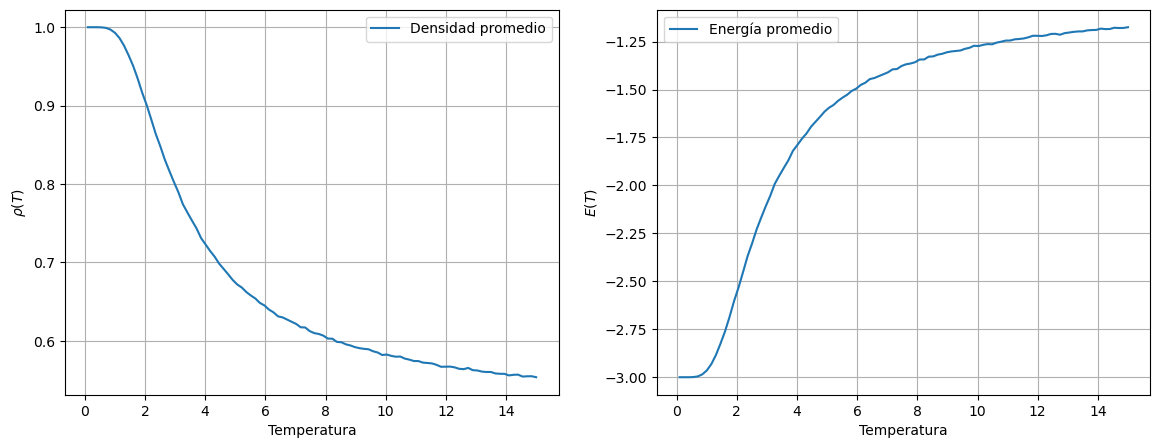

In [8]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(T, rho_vals, label="Densidad promedio")
plt.xlabel("Temperatura")
plt.ylabel(r"$\rho (T)$")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(T, E_vals, label="Energía promedio")
plt.ylabel(r"$E(T)$")
plt.xlabel("Temperatura")
plt.legend()
plt.grid()
plt.show()


Con la energía podemos obtener la capacidad calorífica con:
$$
C_V(T) \;\approx\; \frac{ \langle E^2 \rangle - \langle E \rangle ^2}{k_B T^2}
$$
Entonces ahora hallaremos la capacidad calorífica $C_V$ y veremos para cual $T$ ocurre la transición de fase

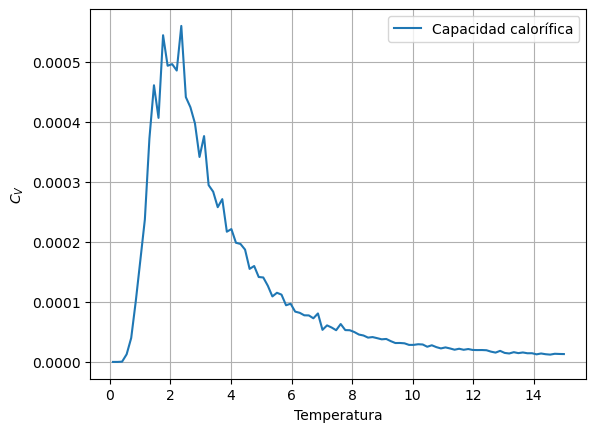

In [9]:
plt.plot(T, C_V_vals, label="Capacidad calorífica")
plt.xlabel("Temperatura")
plt.ylabel("$C_V$")
plt.legend()
plt.grid()
plt.show()

De la gráfica podemos ver que ocurre un cambio drástico de la capacidad calorífica en $T = 2$, esto quiere decir que en esa temperatura ocurre la transición de fase. Esta sería la transición de un líquido (mayor densidad) a un gas (menor densidad).